<a href="https://colab.research.google.com/github/gizemkaratas/Aygaz_YapayZeka/blob/main/ecom_recommendation_sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** Gerekli Kütüphanelerin Yüklenmesi**




In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import numpy as np
import matplotlib.pyplot as plt

import warnings


warnings.filterwarnings('ignore')# Load in the data


In [3]:
# Load in the data
cifar100 = tf.keras.datasets.cifar100

# Distribute it to train and test set
(x_train, y_train), (x_val, y_val) = cifar100.load_data()
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)


169001437/169001437 [==============================] - 11s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [10]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_val.shape)
print("y_test shape:", y_val.shape)
num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
Number of classes: 100


In [12]:

# Veri setini normalize edelim
x_train, x_val = x_train / 255.0, x_val / 255.0

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


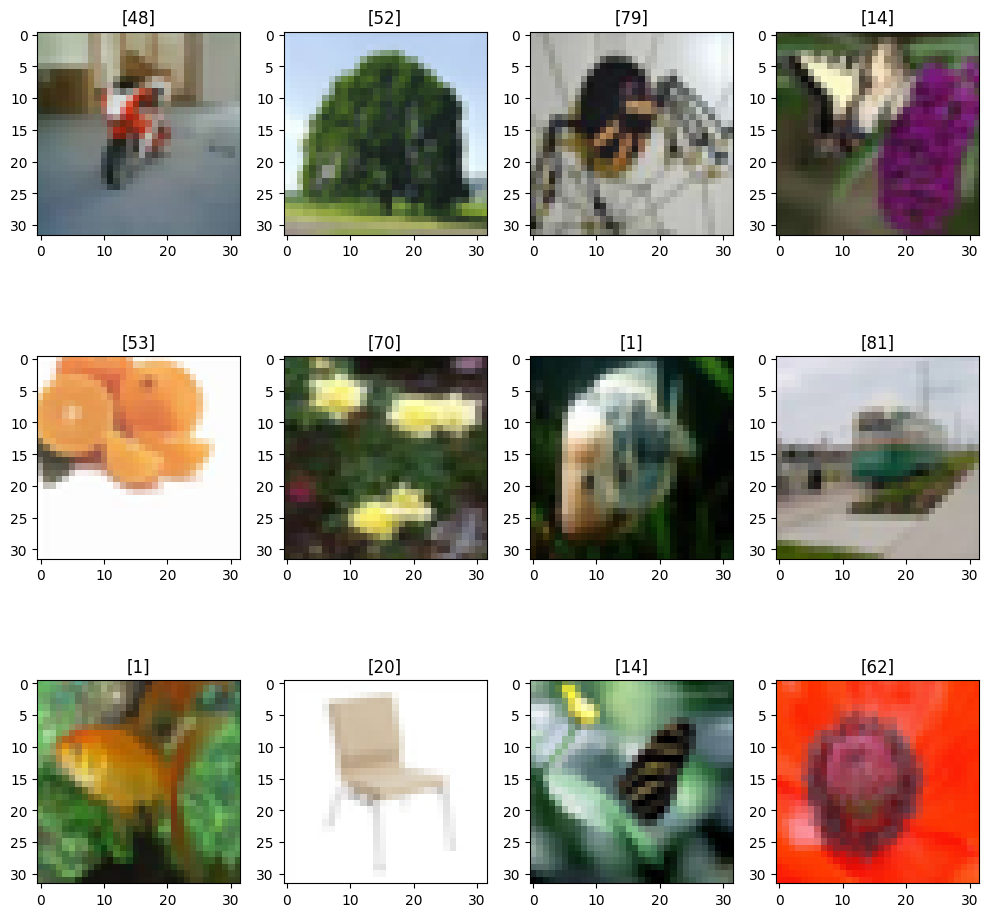

In [13]:
def show_samples(data, labels):
	plt.subplots(figsize=(10, 10))
	for i in range(12):
		plt.subplot(3, 4, i+1)
		k = np.random.randint(0, data.shape[0])
		plt.title(labels[k])
		plt.imshow(data[k])
	plt.tight_layout()
	plt.show()


show_samples(x_train, y_train)


In [14]:
y_train = tf.one_hot(y_train,
					depth=y_train.max() + 1,
					dtype=tf.float64)
y_val = tf.one_hot(y_val,
				depth=y_val.max() + 1,
				dtype=tf.float64)

y_train = tf.squeeze(y_train)
y_val = tf.squeeze(y_val)


In [15]:
model = tf.keras.models.Sequential([
	layers.Conv2D(16, (3, 3), activation='relu',
				input_shape=(32, 32, 3), padding='same'),
	layers.Conv2D(32, (3, 3),
				activation='relu',
				padding='same'),
	layers.Conv2D(64, (3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),
	layers.Conv2D(128, (3, 3),
				activation='relu',
				padding='same'),


	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(256, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(100, activation='softmax')
])

model.compile(
	loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
	optimizer='adam',
	metrics=['AUC', 'accuracy']
)


In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                        

In [ ]:
hist = model.fit(x_train, y_train,
				epochs=5,
				batch_size=64,
				verbose=1,
				validation_data=(x_val, y_val))


Epoch 1/5
782/782 [==============================] - 571s 728ms/step - loss: 1.2474 - auc: 0.9819 - accuracy: 0.6452 - val_loss: 2.6534 - val_auc: 0.8996 - val_accuracy: 0.3951
Epoch 2/5
238/782 [========>.....................] - ETA: 6:13 - loss: 0.7846 - auc: 0.9941 - accuracy: 0.7736

In [18]:
# Test verisi üzerindeki tahminler
test_predictions = model.predict(test_images)
test_predictions_labels = np.argmax(test_predictions, axis=1)

# F1 skoru ve doğruluk hesaplama
accuracy = accuracy_score(test_labels, test_predictions_labels)
f1 = f1_score(test_labels, test_predictions_labels, average='macro')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")



NameError: name 'test_images' is not defined

In [ ]:
# Veri artırma (data augmentation) işlemi
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(x_train)

In [ ]:
 from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train_one_hot, epochs=50, validation_data=(x_test, y_test_one_hot), callbacks=[early_stopping])

In [ ]:
# Test verileriyle tahmin yapalım
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 4ms/step


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving WhatsApp Image 2024-05-15 at 10.49.28.jpeg to WhatsApp Image 2024-05-15 at 10.49.28.jpeg


In [ ]:
# Örnek insan görseli yükleyelim
img_path = 'WhatsApp Image 2024-05-15 at 10.49.28.jpeg'
img = image.load_img(img_path, target_size=(32, 32))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [ ]:
# Modelin tahmini
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)
print(f"Predicted class: {pred_class}")

1/1 [==============================] - 0s 24ms/step
Predicted class: [5]
